## Bank Term Deposit Acceptance forecasting

Obiettivo di questo assignment è la valutazione delle competenze tecniche del candidato e la sua modalità di approccio ad un problema di Data Science. Nello specifico è richiesto di sviluppare un modello predittivo in grado di indicare se un cliente intercettato da una campagna di marketing da parte di una banca decide di sottoscrivere o meno un deposito bancario a termine (bank term deposit).

#### Dataset: ####

All'interno della cartella **data**  viene fornito il file **bank-dataset.csv** che contiene le campagne marketing telefoniche effettuate da una banca per proporre l'acquisto del prodotto bancario.
I dettagli del dataset sono forniti all'interno del file: **bank-names.txt**.
La variabile target che indica se il cliente accetta o meno la sottoscrizione del deposito bancario è contenuta nel medesimo file con field name "y".

#### Assignement: ####

Richiesta di questo assignment è la costruzione di un modello predittivo con performance soddisfacenti per il candidato dando evidenza di tutti gli step tipici che dovrebbero essere affrontati in un progetto di Data Science: dalla pulizia e preparazione del dato fino al testing delle performance del modello costruito.

Il notebook svolto dovrà essere opportunamente commentato e dovrà essere consegnato tramite condivisione di un repository github personale accessibile che ne permetta la riproduzione.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV



# 1. Split in Train and Test

I split in train and test from the beginning because, as I will show below, there are many missing values (NaN or "unkown" values) and I can't use the test set to influence the train set, otherwise I would have a data leakage.

In [2]:
df = pd.read_csv (r'data/bank-dataset.csv')

In [3]:
train, test = train_test_split(df, test_size=0.2, random_state=25) # I use the classical 80% - 20% division for train and test resp.

In [4]:
train.shape , test.shape

((34477, 17), (8620, 17))

In [5]:
train = train.reset_index()
train.drop(columns=["index"],inplace=True)
test = test.reset_index()
test.drop(columns=["index"],inplace=True)

# 2. Explorative Data Analysis (EDA)

In [6]:
train.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,38.0,blue-collar,married,secondary,no,0,no,no,unknown,6,jun,361.0,1,-1,0,unknown,no
1,51.0,services,divorced,secondary,no,0,no,no,telephone,30,jul,273.0,4,-1,0,unknown,no
2,46.0,admin.,married,secondary,no,-143,yes,no,unknown,23,may,1034.0,9,-1,0,unknown,no
3,48.0,services,married,secondary,no,400,yes,yes,cellular,13,aug,158.0,1,-1,0,unknown,no
4,25.0,management,single,tertiary,no,1348,yes,no,unknown,8,may,109.0,1,-1,0,unknown,no
5,42.0,admin.,divorced,secondary,no,-172,yes,yes,unknown,4,jun,179.0,1,-1,0,unknown,no
6,58.0,services,married,secondary,no,627,no,no,cellular,13,aug,110.0,4,-1,0,unknown,no
7,39.0,technician,married,secondary,no,376,no,no,unknown,20,jun,160.0,3,-1,0,unknown,no
8,34.0,admin.,married,secondary,no,396,yes,no,cellular,16,jul,101.0,3,-1,0,unknown,no
9,32.0,blue-collar,single,secondary,no,53,yes,no,cellular,18,nov,276.0,1,195,1,failure,no


In [7]:
train.describe()

,age,balance,day,duration,campaign,pdays,previous
count,34461.000000,34477.000000,34477.000000,34417.000000,34477.000000,34477.00000,34477.000000
mean,41.321726,1354.293558,15.871886,244.161461,2.806422,38.51675,0.547843
std,12.270030,3051.555995,8.446042,238.330075,3.175130,98.69703,2.375331
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.00000,0.000000
25%,33.000000,67.000000,8.000000,101.000000,1.000000,-1.00000,0.000000
50%,39.000000,435.000000,16.000000,174.000000,2.000000,-1.00000,0.000000
75%,48.000000,1405.000000,21.000000,302.000000,3.000000,-1.00000,0.000000
max,150.000000,102127.000000,99.000000,3881.000000,63.000000,871.00000,275.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34477 entries, 0 to 34476
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        34461 non-null  float64
 1   job        34477 non-null  object 
 2   marital    34477 non-null  object 
 3   education  34477 non-null  object 
 4   default    34477 non-null  object 
 5   balance    34477 non-null  int64  
 6   housing    34477 non-null  object 
 7   loan       34477 non-null  object 
 8   contact    34431 non-null  object 
 9   day        34477 non-null  int64  
 10  month      34477 non-null  object 
 11  duration   34417 non-null  float64
 12  campaign   34477 non-null  int64  
 13  pdays      34477 non-null  int64  
 14  previous   34477 non-null  int64  
 15  poutcome   34467 non-null  object 
 16  y          34477 non-null  object 
dtypes: float64(2), int64(5), object(10)
memory usage: 4.5+ MB


In [9]:
# trasform our output y in numeric (binary 0/1)
train['y'] = train['y'].replace(['yes'],1)
train['y'] = train['y'].replace(['no'],0)

test['y'] = test['y'].replace(['yes'],1)
test['y'] = test['y'].replace(['no'],0)

Missing values:

In [10]:
# check missing values
print(train.isna().values.any())
print(train.isna().sum())

True
age          16
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact      46
day           0
month         0
duration     60
campaign      0
pdays         0
previous      0
poutcome     10
y             0
dtype: int64


In [11]:
train[train.isna().any(axis=1)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
91,49.0,management,married,tertiary,no,2037,no,no,unknown,5,oct,NaN,1,-1,0,unknown,0
179,41.0,blue-collar,married,primary,no,178,yes,no,NaN,20,jul,5.0,1,791,1,failure,0
235,35.0,admin.,married,secondary,no,2374,yes,no,NaN,25,aug,5.0,1,14,7,success,0
550,27.0,technician,married,tertiary,no,176,yes,no,cellular,18,may,NaN,2,350,7,other,0
846,57.0,entrepreneur,married,unknown,no,618,yes,no,unknown,8,may,NaN,7,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33605,NaN,retired,married,secondary,no,668,no,no,telephone,2,jul,363.0,1,-1,0,unknown,1
33633,42.0,services,single,unknown,no,4800,no,no,unknown,20,jun,NaN,11,-1,0,unknown,0
33687,36.0,management,single,tertiary,no,72,yes,yes,cellular,21,nov,NaN,7,-1,0,unknown,0
34072,57.0,services,married,secondary,no,530,yes,no,telephone,15,may,NaN,7,360,7,failure,0


I have few missing values. I would deal with them in the next section.

Let's give a first look to the distribution of all features

In [12]:
cols = list(train.columns)

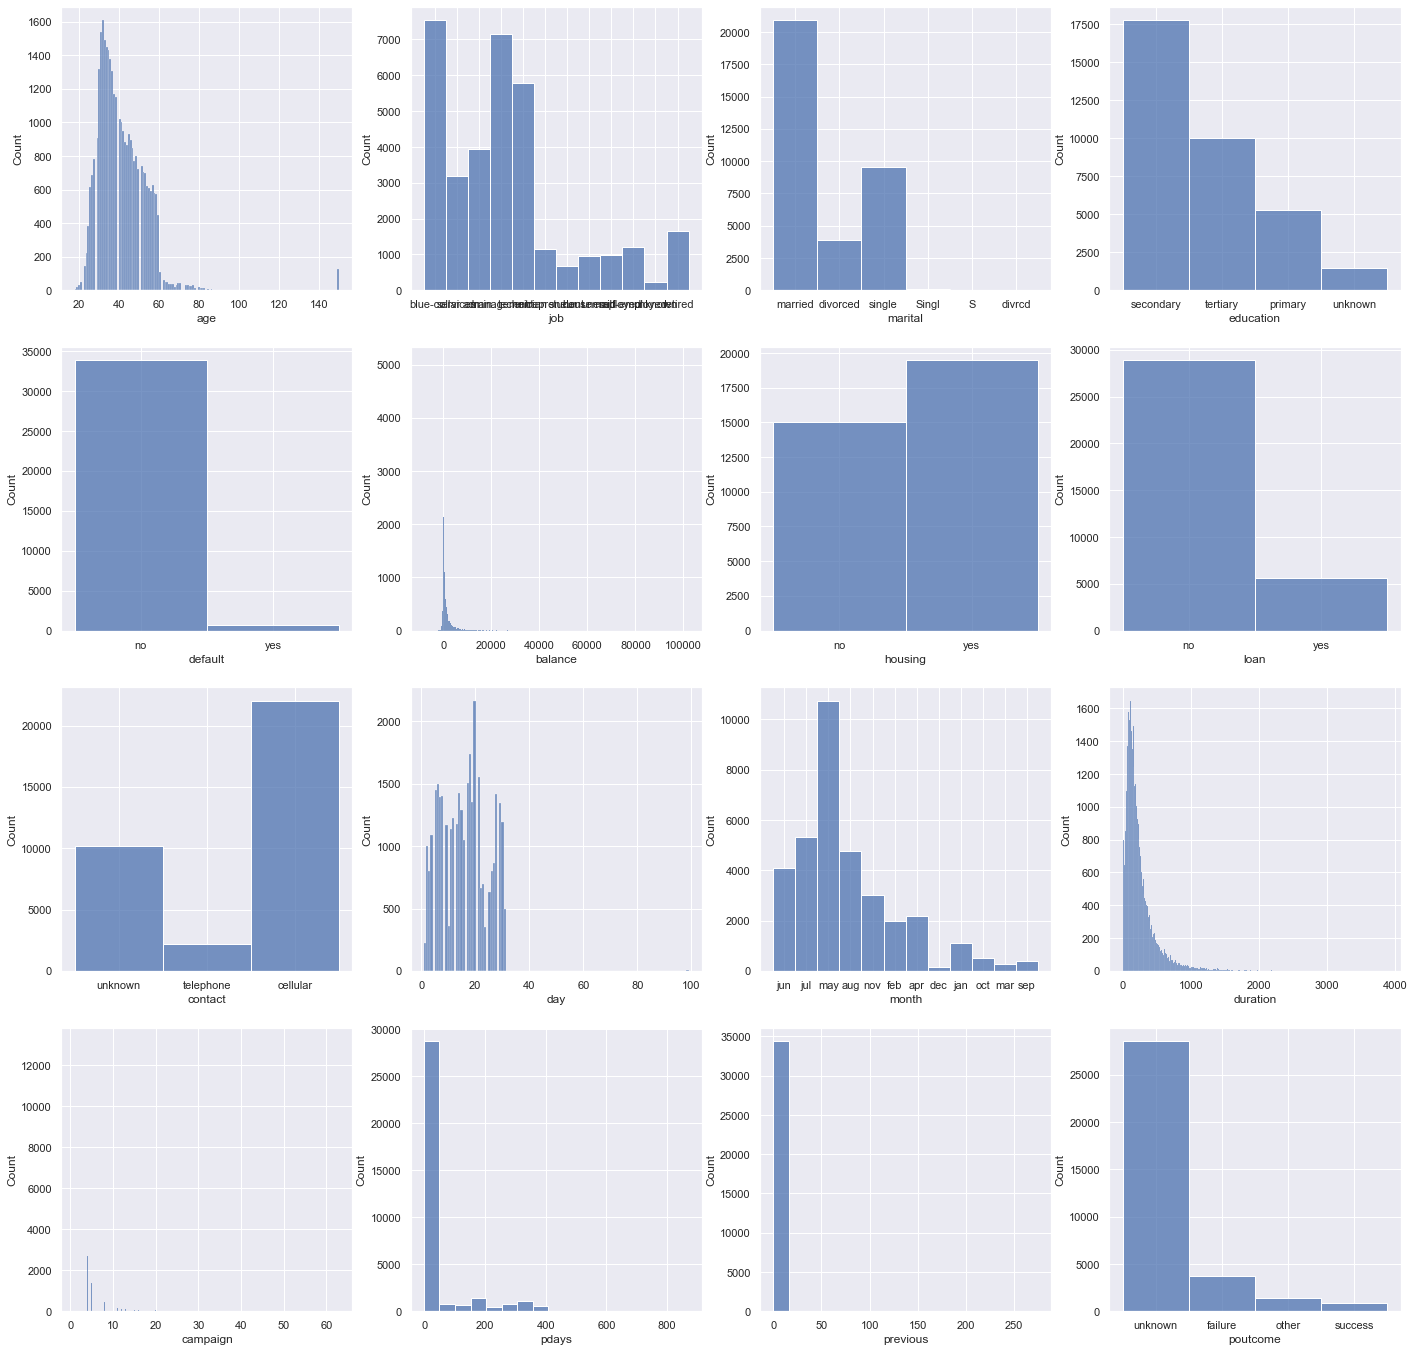

In [15]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(4, 4, figsize=(24, 24))

sns.histplot(data=train, x=cols[0], ax=axs[0, 0])
sns.histplot(data=train, x=cols[1], ax=axs[0, 1])
sns.histplot(data=train, x=cols[2], ax=axs[0, 2])
sns.histplot(data=train, x=cols[3], ax=axs[0, 3])
sns.histplot(data=train, x=cols[4], ax=axs[1, 0])
sns.histplot(data=train, x=cols[5], ax=axs[1, 1])
sns.histplot(data=train, x=cols[6], ax=axs[1, 2])
sns.histplot(data=train, x=cols[7], ax=axs[1, 3])
sns.histplot(data=train, x=cols[8], ax=axs[2, 0])
sns.histplot(data=train, x=cols[9], ax=axs[2, 1])
sns.histplot(data=train, x=cols[10], ax=axs[2, 2])
sns.histplot(data=train, x=cols[11], ax=axs[2, 3])
sns.histplot(data=train, x=cols[12], ax=axs[3, 0])
sns.histplot(data=train, x=cols[13], ax=axs[3, 1])
sns.histplot(data=train, x=cols[14], ax=axs[3, 2])
sns.histplot(data=train, x=cols[15], ax=axs[3, 3])

plt.show()

<AxesSubplot:xlabel='job', ylabel='Count'>

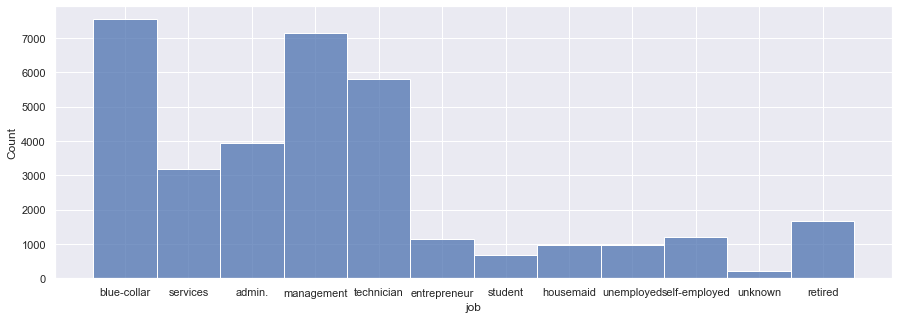

In [16]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.histplot(data=train, x=cols[1])

There are many "unkown" values in several columns (in particular poutcome and contact). These are missing values as well. I will take them into consideration in next section.

In [17]:
# There are some wrong values in "martial":
# "Singl" and "S" -> "single"
# "divrcd" -> "divorced"

train = train.replace(["Singl","S","Single"], 'single')
train = train.replace('divrcd', 'divorced')
test = test.replace(["Singl","S","Single"], 'single')
test = test.replace('divrcd', 'divorced')


In [18]:
# save categorical and numerical variables in two separated lists
cat_var = [cols[1],cols[2],cols[3],cols[4],cols[6],cols[7],cols[8],cols[9],cols[10],cols[15]]
num_var = list(set(cols).difference(cat_var))
num_var.remove('y') # I don't consider the output variable in these lists

In [19]:
# Function to label the count on top of each bar in graph
def label_values(ax, spacing=5):
    total = 0
    for rect in ax.patches:
        total += rect.get_height()

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        
        va = 'bottom'
        
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.2f}, {:.2f}".format(y_value, y_value/total*100)
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va) 

a) Categorical variables:

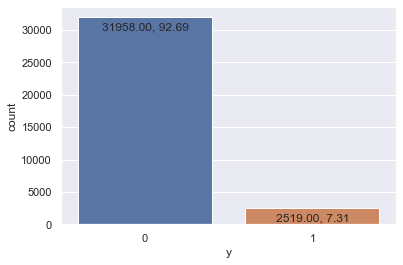

In [20]:
# output: y
ax = sns.countplot(x = train["y"])
label_values(ax, spacing=-15)
plt.show()

We are in the case of imbalanced dataset. 

Job


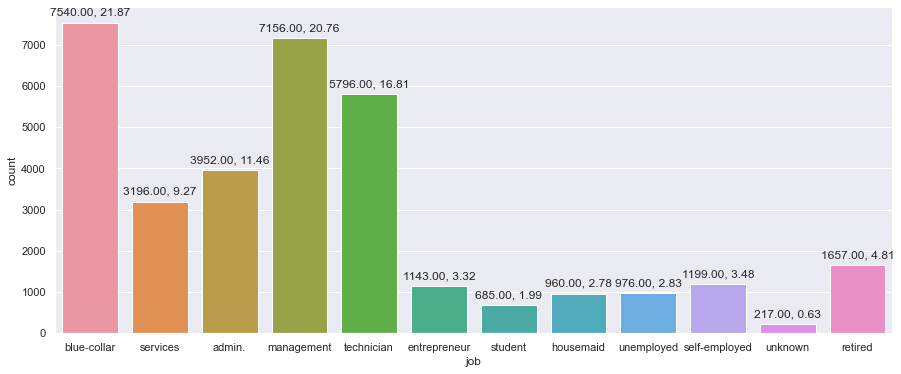

Marital


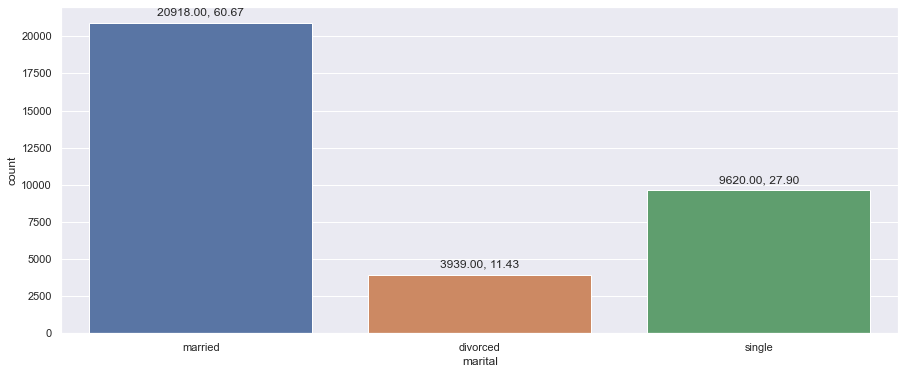

Education


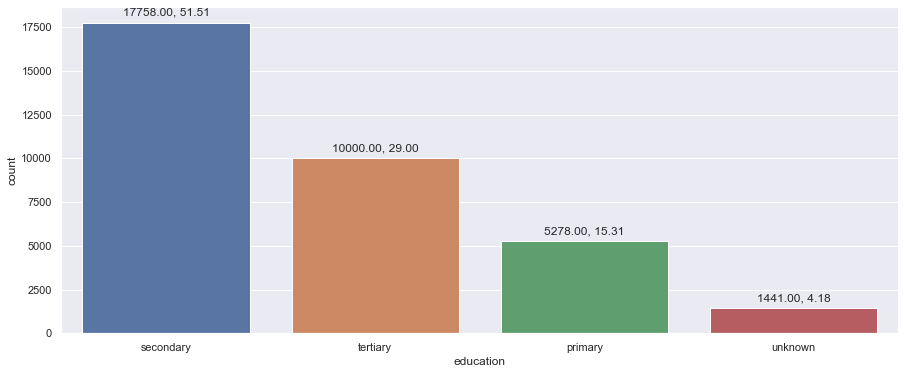

Default


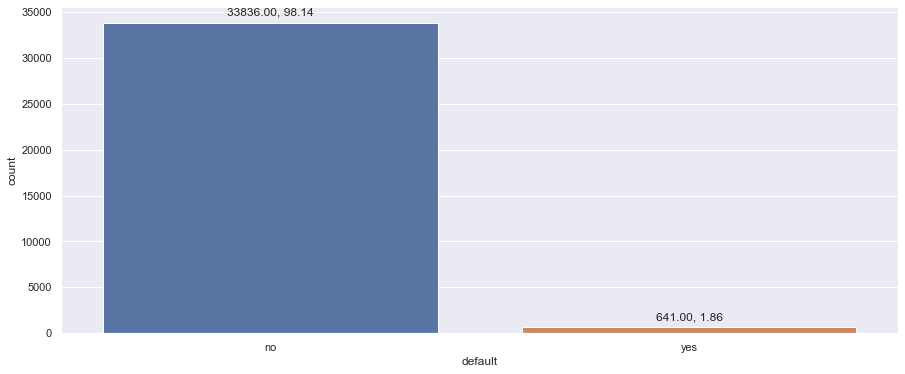

Housing


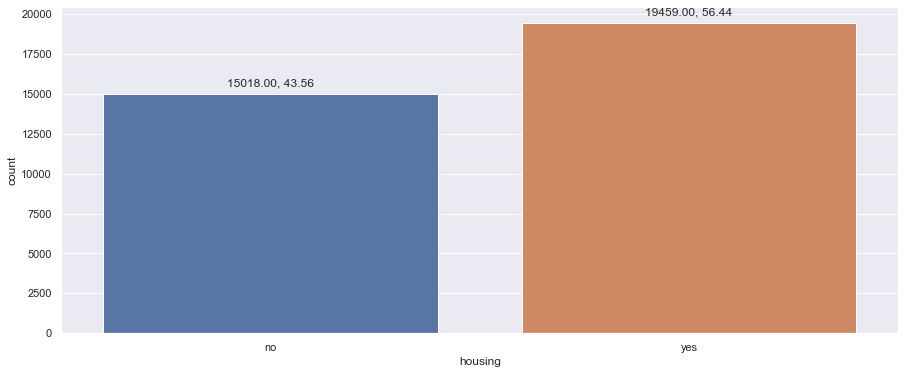

Loan


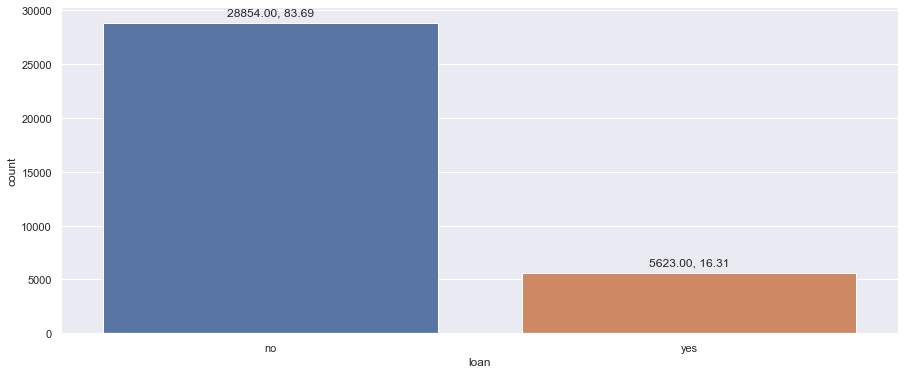

Contact


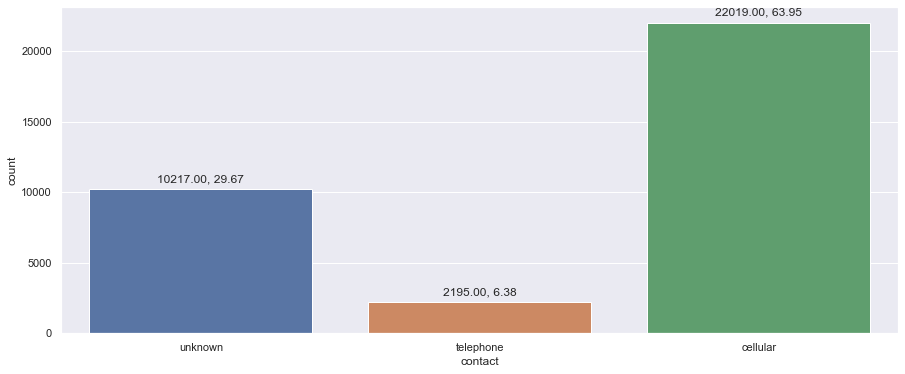

Day


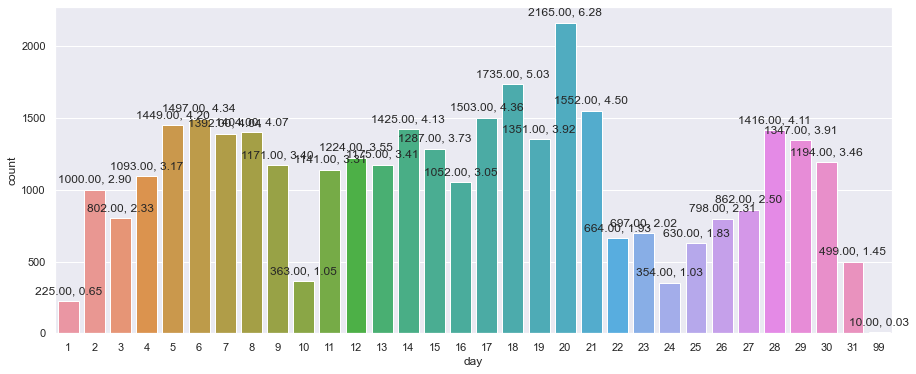

Month


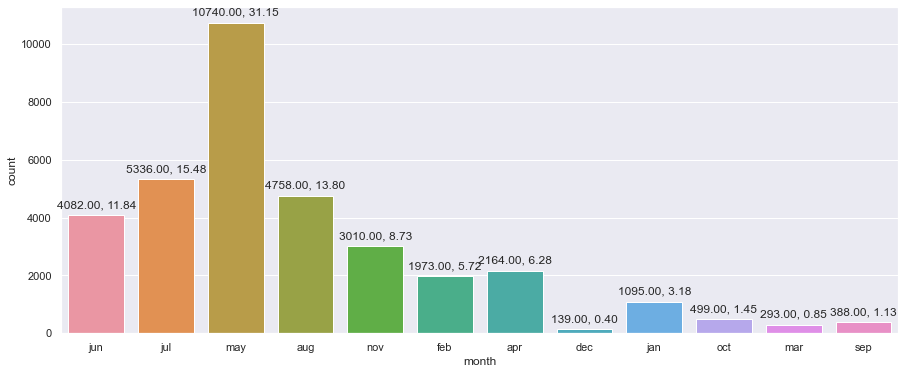

Poutcome


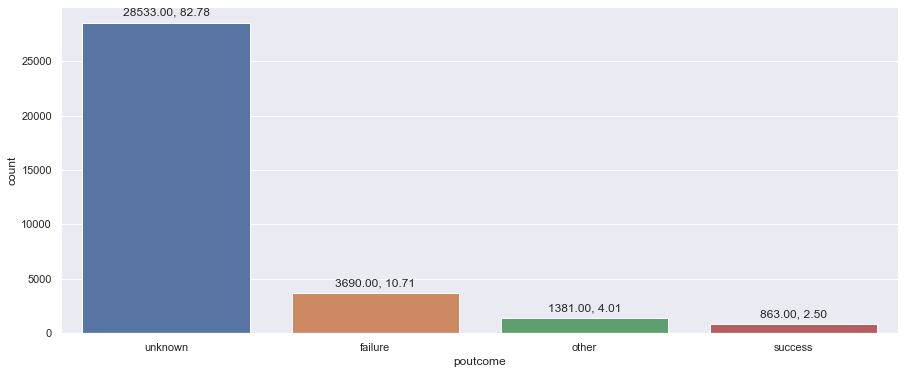

In [21]:
for column in cat_var:
    plt.figure(figsize=(15, 6))
    print(column.title())
    ax = sns.countplot(x = train[column])
    label_values(ax)
    plt.show()

In [22]:
perc_of_yes = train["y"].value_counts()[1]/train["y"].value_counts().sum()
perc_of_yes

0.07306320155465963

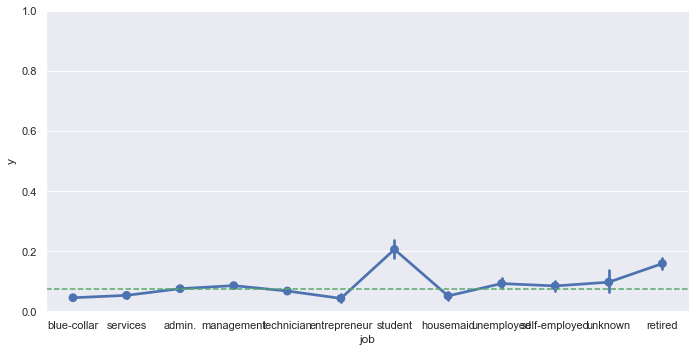

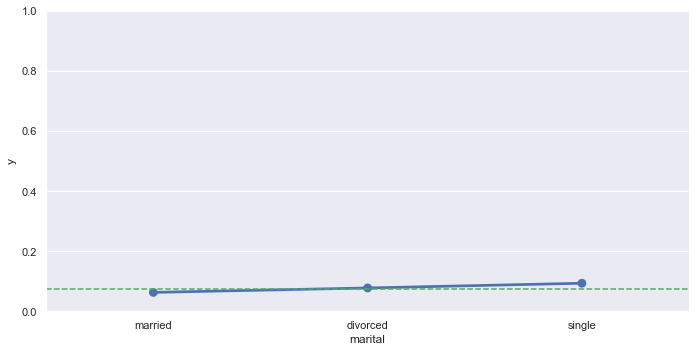

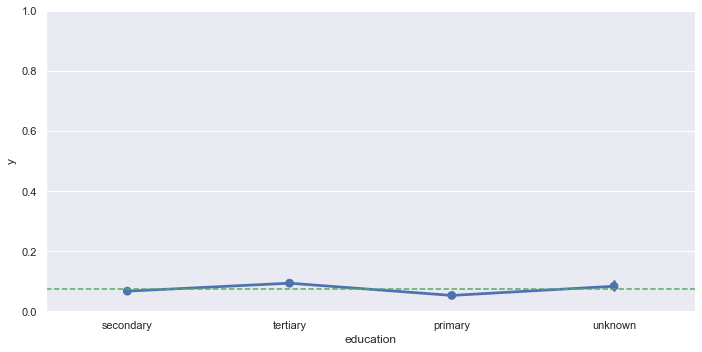

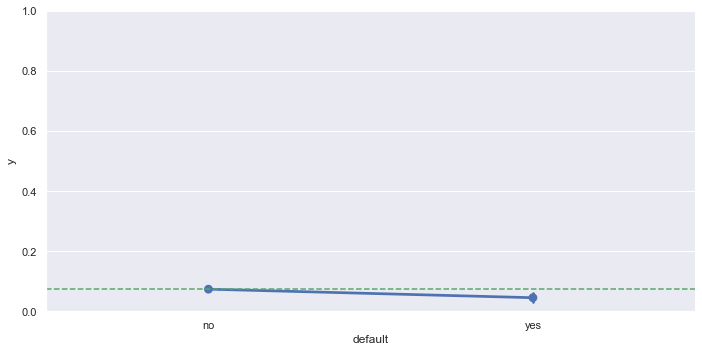

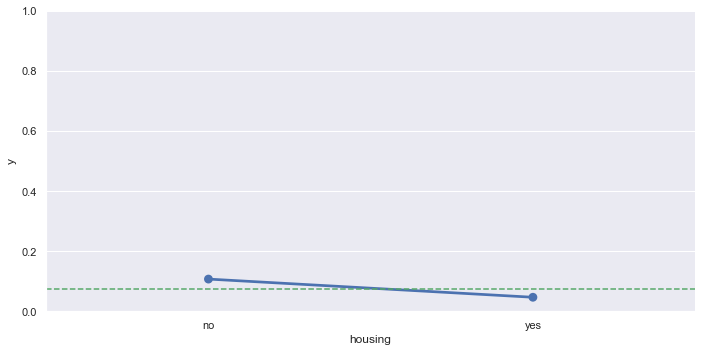

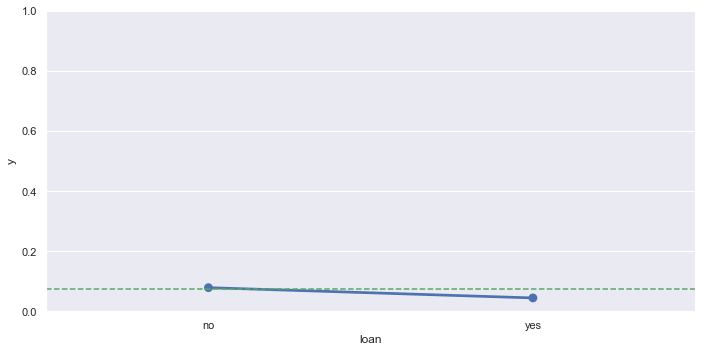

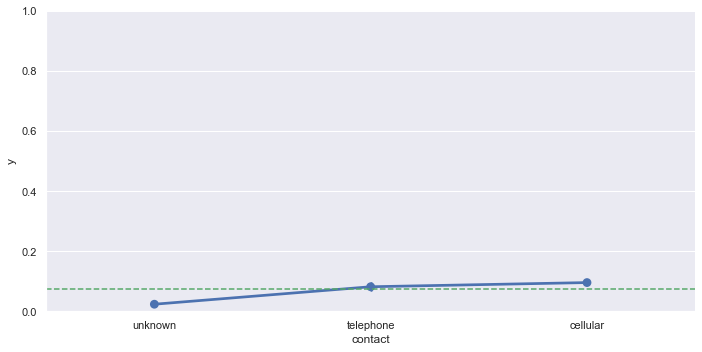

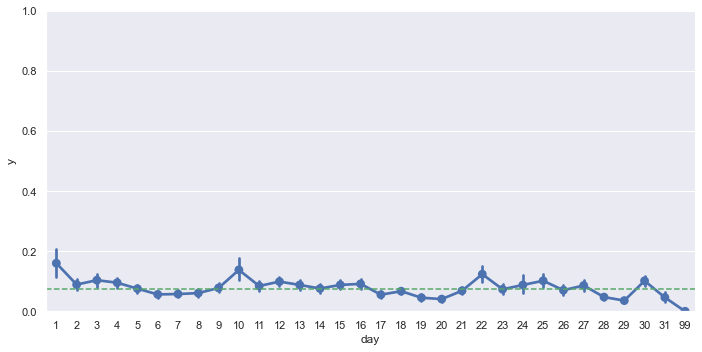

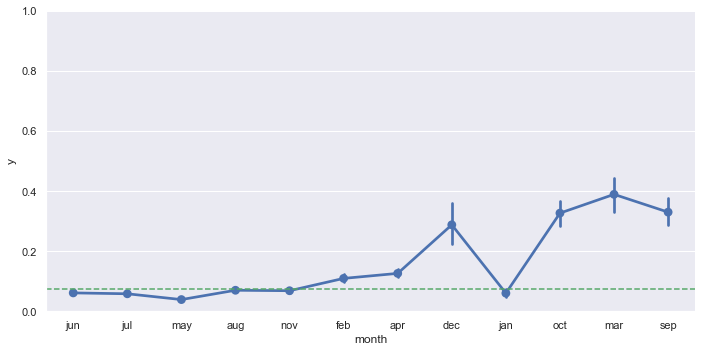

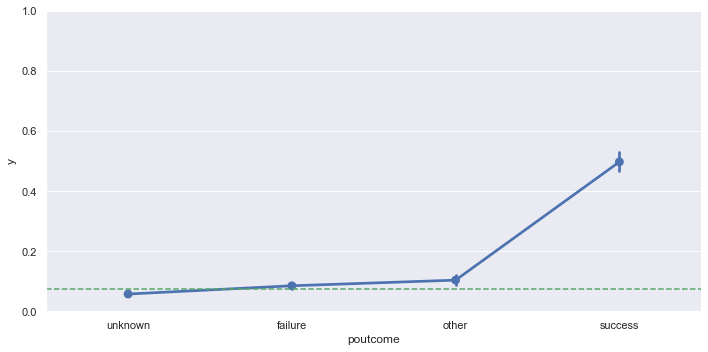

In [23]:
# Generate categorical plots for features
for col in cat_var:
    g = sns.catplot(data=train, x=col, y='y', kind='point', aspect=2)
    ax = g.axes[0]
    ax[0].axhline(perc_of_yes, ls='--', c='g') # share of "yes" in subscription (y=1)

    plt.ylim(0, 1)


In order to have more significant evidence of the fact that our categorical variables are related to the output variable y, I compute some chi-square test of indipendence.

In [24]:
for col in cat_var:
    print(col)
    # compute the chi-square test of independence between each cat. var. and the output variable y
    crosstab = pd.crosstab(train[col], train["y"]) # compute the crosstable
    pval=stats.chi2_contingency(crosstab)[1] # compute chi-squared test and return pvalue
    print("pvalue is {}".format(pval))

job
pvalue is 1.726758970958669e-103
marital
pvalue is 1.1571286789548567e-20
education
pvalue is 8.625907026134954e-23
default
pvalue is 0.007917361373010808
housing
pvalue is 2.0793482045922952e-101
loan
pvalue is 2.680529619786449e-19
contact
pvalue is 3.4293599885789785e-117
day
pvalue is 1.585789036187839e-39
month
pvalue is 0.0
poutcome
pvalue is 0.0


Since all pvalues are lower than 0.05-threshold, we refuse the null hypothesis, so it means that the proportion of people who subscribed differs between categories for each categorical variable.

Some insights on categorical variables:

1. Job: students and retired people subscribe more than other job categories and more than the average of subscriptions, even if they are few comparing to the total (2% and 4.8% resp.). Note that there's a 0.63% of unkown values.
2. Marital: around 60% of client have been approached are married. Single people are a little more in favour of subscribing.
3. Education: Clients with university degree and high school were reached out more in comparison to others and they have higher success rate as well (in terms of subscriptions). Also note 4.18% of "unkown".
4. Default: Default variable is not really useful for our purposes, since 98.14% of people do not have it. However, among that 1.86% that has it, the share of subscriptions is lower than the average. In any case, I will drop this column since I believe the benefits from this are lower than cons (i.e, more complex dataset).
5. Housing: who has an housing loan is a bit more resilient to subscribe (w.r.t both who does not have it and average share of subscriptions)
6. Loan: around 84% of client does not have a personal loan. Note that who has it is subscribing less (same logic as before).
7. Contact: Around 64% of calls come from cellular, but there is around a 30% of "unkown" who almost never did the subscription. 
8. Day: I do not believe this feature is relevant because it does not indicate the day of the week, but only the number.
9. Month: Most of people have been approached in summer. Success rate is very high for December - October - March - September (but it is also true that we have few data for these months). May is the month highest called people, but lowest success rate.
10. poutcome: If a client took the term deposit last time then there are higher chances of that client subscribing to it again. I expected clients that didn't subscribe for last campaign to be more resilient also for this campaign, but this is not the case. Note that there are 82.78% of "unkown" values. These are clients that have not been reached out during the previous campaign. 

In [25]:
# based on previous insights, I drop "default" and "day".
train.drop(columns = ["default","day"], inplace = True)
test.drop(columns = ["default","day"], inplace = True)

(b) Numerical variables

Age


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


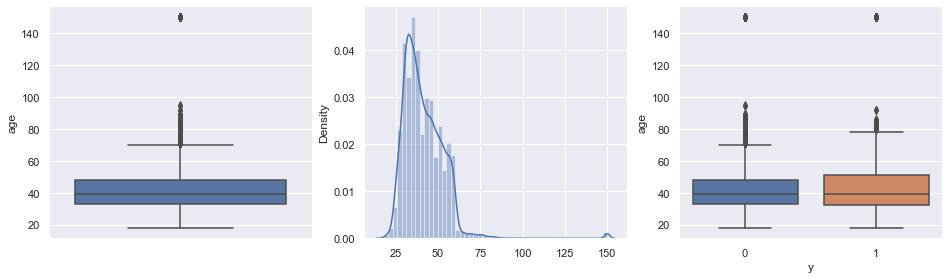

Pdays


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


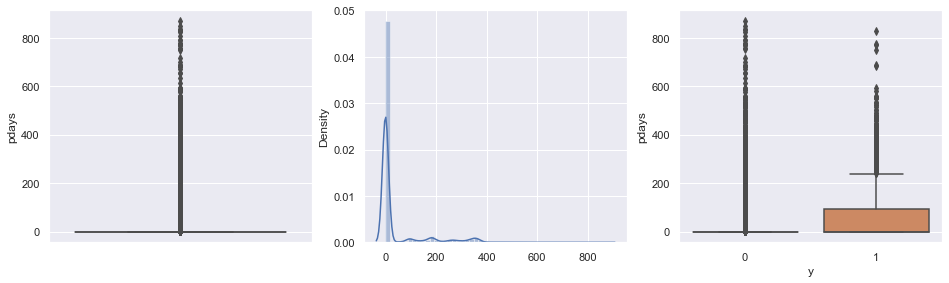

Previous


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


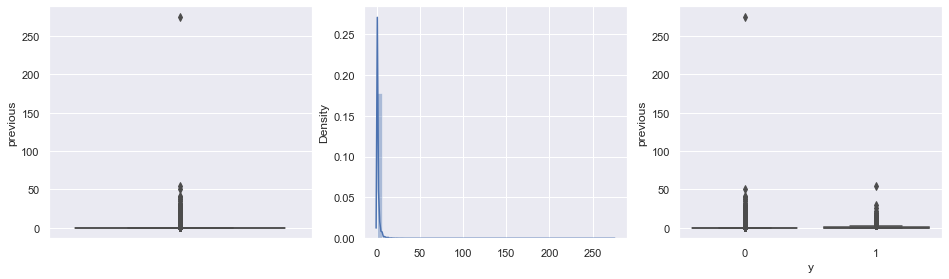

Duration


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


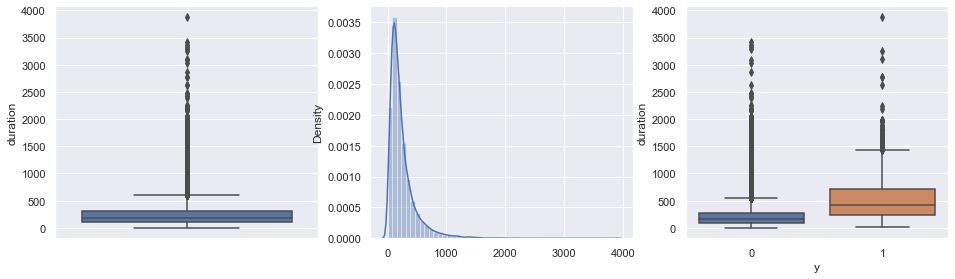

Campaign


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


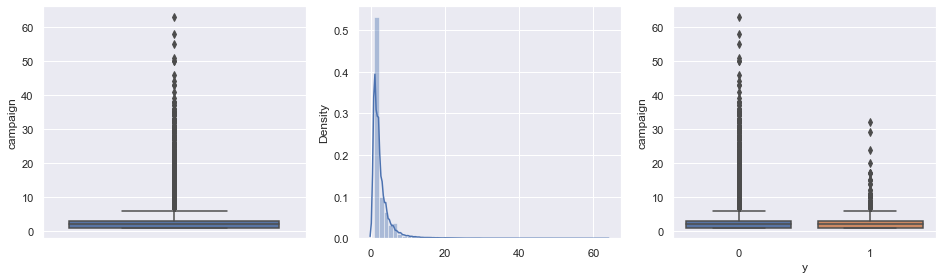

Balance


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


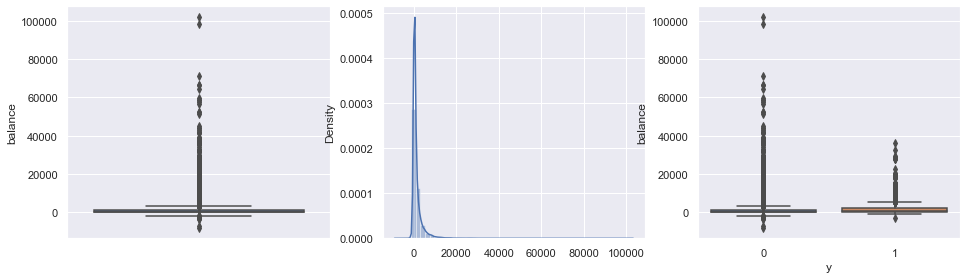

In [26]:
i = 1
for column in num_var:
    print(column.title())
    plt.subplots(figsize=(16, 35))
    plt.subplot(len(num_var) + 1, 3, i)
    sns.boxplot(y = train[column])
    i += 1
    plt.subplot(len(num_var) + 1, 3, i)
    sns.distplot(x = train[column])
    i += 1
    plt.subplot(len(num_var) + 1, 3, i)
    sns.boxplot(x = train["y"], y = train[column])
    i += 1
    plt.show()

Let's get deeper insights.

1. P-days

In [27]:
train["pdays"].value_counts()/train["pdays"].value_counts().sum()

-1      0.827769
 182    0.003075
 92     0.002523
 91     0.002378
 183    0.002146
          ...   
 425    0.000029
 760    0.000029
 474    0.000029
 45     0.000029
 403    0.000029
Name: pdays, Length: 505, dtype: float64

Note that 82.78% of data are classified as "-1" meaning that they have not been contacted during the previous campaign (these are the "unkown" values we have seen in poutcome). From the boxplot above, we can see that the share of success is larger for people who has been reached out during previous campaign. Let's get more insights on this.

In [28]:
X_pdays = train[["pdays","y"]]
X_no_prev_pdays = X_pdays[X_pdays["pdays"] == -1]
X_prev_pdays = X_pdays[X_pdays["pdays"] != -1]

In [29]:
print(X_no_prev_pdays["y"].value_counts()/X_no_prev_pdays["y"].value_counts().sum())
print("len:" + str(len(X_no_prev_pdays)))

0    0.94278
1    0.05722
Name: y, dtype: float64
len:28539


In [30]:
print(X_prev_pdays["y"].value_counts()/X_prev_pdays["y"].value_counts().sum())
print("len:" + str(len(X_prev_pdays)))

0    0.850792
1    0.149208
Name: y, dtype: float64
len:5938


Note, as already mentioned, that there is a significant difference in success rate between the 2 new datasets, namely people that were contacted in the past are more in favour of taking out a subscription.

<AxesSubplot:xlabel='pdays', ylabel='Count'>

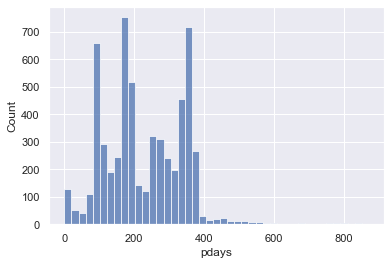

In [31]:
sns.histplot(X_prev_pdays["pdays"])

In [32]:
# I divide the people "not new" in 10 blocks based on quantiles to see if there is a pattern
X_prev_pdays["quantile"] = pd.qcut(X_prev_pdays["pdays"], q=np.arange(0,1.1,0.1),
                         labels=np.arange(1,11,1)) 

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_22320\1115030062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_prev_pdays["quantile"] = pd.qcut(X_prev_pdays["pdays"], q=np.arange(0,1.1,0.1),


In [33]:
X_prev_pdays.groupby(["quantile"]).mean()

,pdays,y
quantile,,
1,64.479104,0.311940
2,101.015444,0.245174
3,142.139344,0.118033
4,176.169748,0.184874
5,189.754717,0.219554
6,239.348562,0.071066
7,283.864636,0.089679
8,331.400651,0.045603
9,353.661264,0.050243


In [34]:
X_prev_pdays.groupby(["quantile"]).count()

,pdays,y
quantile,,
1,670,670
2,518,518
3,610,610
4,595,595
5,583,583
6,591,591
7,591,591
8,614,614
9,617,617


(0.0, 1.0)

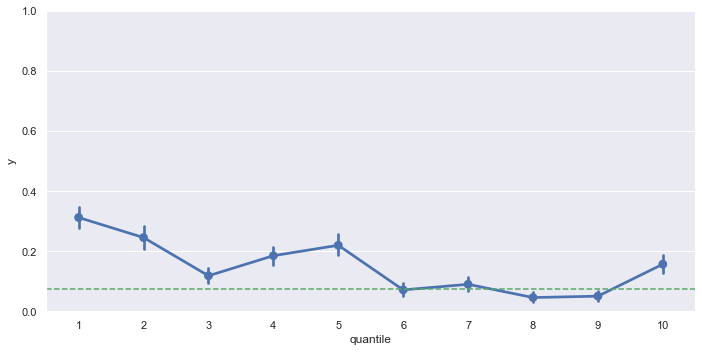

In [35]:
g = sns.catplot(data=X_prev_pdays, x='quantile', y='y', kind='point', aspect=2)
ax = g.axes[0]
ax[0].axhline(perc_of_yes, ls='--', c='g') # share of "yes" in subscription (y=1)
plt.ylim(0, 1)

Note that lower is the number of days that passed by after the client was last contacted from a previous campaign, and higher is the probability that they will take out a subscription (on average, because 3rd and 10th quantile are bucking the trend).

Based on this analysis, I will assign a symbolic value of 999 days for people with "-1" flag, in order to set a sufficient high number that follows the above trend. In addition, since we have clearly some outliers that might have a negative impact on the model, I cap all values over 999 to 999. 

In [36]:
train['pdays'] = train['pdays'].replace([-1],999)
train['pdays'] = train['pdays'].apply(lambda x: 999 if x > 999 else x)

2. Balance

I proceed in a similar way done with pdays.

In [37]:
X_bal = train[["balance","y"]]

In [38]:
X_bal["quantile"] = pd.qcut(X_bal["balance"], q=np.arange(0,1.1,0.1),
                         labels=np.arange(1,11,1)) 

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_22320\1335961044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_bal["quantile"] = pd.qcut(X_bal["balance"], q=np.arange(0,1.1,0.1),


In [39]:
X_bal.groupby(["quantile"]).mean()

,balance,y
quantile,,
1,-168.739262,0.039404
2,7.980015,0.044581
3,68.612394,0.053785
4,190.814373,0.066628
5,345.145344,0.071657
6,554.085292,0.077749
7,875.883802,0.080556
8,1431.776457,0.086112
9,2571.995933,0.108077


(0.0, 1.0)

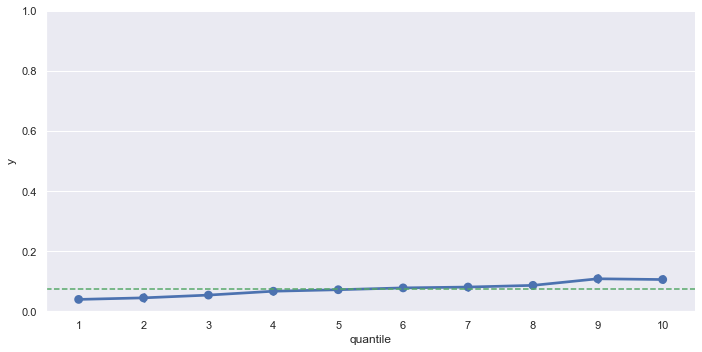

In [40]:
g = sns.catplot(data=X_bal, x='quantile', y='y', kind='point', aspect=2)
ax = g.axes[0]
ax[0].axhline(perc_of_yes, ls='--', c='g') # share of "yes" in subscription (y=1)
plt.ylim(0, 1)

It looks that there is a positive trend: higher the average yearly balance and higher the chances to subscribe.

I leave the class like this (of course I will normalize it in order not to give too much weight to outliers).

3. Duration

From above boxplots I can clearly see that there is a correlation between longer calls and success rate. However, I can't use this variable for predicting the outcome y because after the call the output (if the client has stipulated a subscription or not) is already known. For this reason I drop it in next section.

In [41]:
train.drop(columns = ["duration"], inplace = True)
test.drop(columns = ["duration"], inplace = True)

4. Campaign

From boxplots above, it looks that people that have been reached out several times (e.g, >35) are more resilient to take out a subscription, meaning that marketing harrassment has a negative effect. For this reason a cap all values over 8 (outliers) to 8 for similar reasons seen before.

In [42]:
train['campaign'] = train['campaign'].apply(lambda x: 8 if x > 8 else x)
test['campaign'] = test['campaign'].apply(lambda x: 8 if x > 8 else x)

I want to check if there is a trend in success rate w.r.t number of contacts.

(0.0, 1.0)

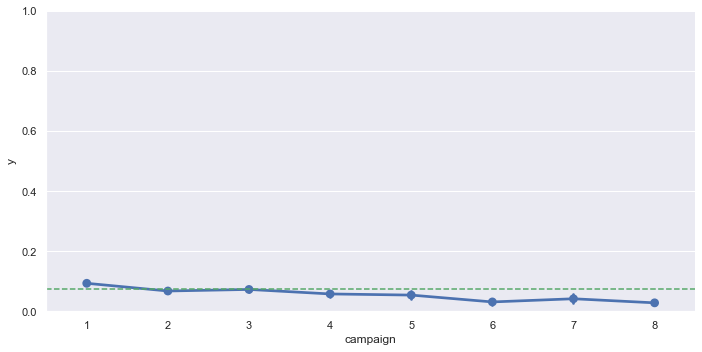

In [43]:
g = sns.catplot(data=train, x='campaign', y='y', kind='point', aspect=2)
ax = g.axes[0]
ax[0].axhline(perc_of_yes, ls='--', c='g') # share of "yes" in subscription (y=1)
plt.ylim(0, 1)

In [44]:
crosstab = pd.crosstab(train["campaign"], train["y"]) # compute the crosstable
pval=stats.chi2_contingency(crosstab)[1] # compute chi-squared test and return pvalue
print("pvalue is {}".format(pval))

pvalue is 2.313199072091411e-37


It looks that there is negative trend. 

5. Age

A first remake is that the bank is not very interested in contacting the older population. However, it looks that the success rate is slightly higher for over 60 y.o. Let's check it.

In [45]:
X_age = train[["age","y"]]
X_age["quantile"] = pd.qcut(X_age["age"], q=[0., 0.2, 0.4, 0.6, 0.8, 0.95, 1.0],
                         labels=[1,2,3,4,5,6]) 

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_22320\3087089629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_age["quantile"] = pd.qcut(X_age["age"], q=[0., 0.2, 0.4, 0.6, 0.8, 0.95, 1.0],


In [46]:
X_age.groupby(["quantile"]).mean()

,age,y
quantile,,
1,29.087574,0.087694
2,34.469147,0.062750
3,39.752405,0.059327
4,47.328721,0.057625
5,55.348912,0.056721
6,73.822155,0.238131


In [47]:
X_age.groupby(["quantile"]).min()

,age,y
quantile,,
1,18.0,0
2,33.0,0
3,37.0,0
4,44.0,0
5,52.0,0
6,60.0,0


In [48]:
X_age.groupby(["quantile"]).count()

,age,y
quantile,,
1,8313,8313
2,5753,5753
3,7484,7484
4,6577,6577
5,5007,5007
6,1327,1327


(0.0, 1.0)

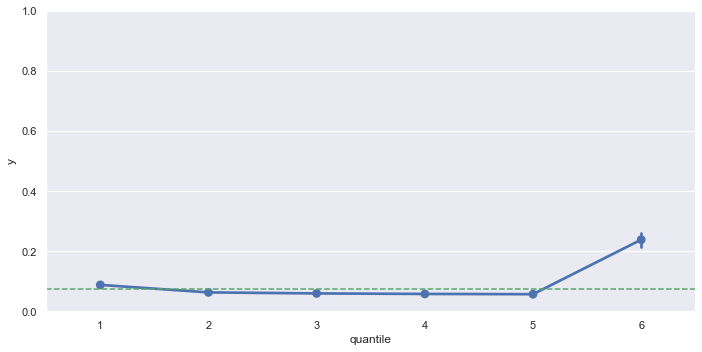

In [49]:
g = sns.catplot(data=X_age, x='quantile', y='y', kind='point', aspect=2)
ax = g.axes[0]
ax[0].axhline(perc_of_yes, ls='--', c='g') # share of "yes" in subscription (y=1)
plt.ylim(0, 1)

Since there is not a significant trend in age, except for very old and very young people, I create 3 categories: 18-33, 34-59, >=60.
I will Label Encode this variable then.

6. Previous

The boxplots above are not very clear due to the presence of outliers and the fact that we have the same amount of 0 as the "-1" we have seen in pdays. In fact, these are clients that were not reached out during the previous campaign.

I cap outliers since they are equally present in both 'y' classes.

In [50]:
len(train[train['previous'] > 5])

753

In [51]:
train['previous'] = train['previous'].apply(lambda x: 5 if x > 5 else x)
test['previous'] = test['previous'].apply(lambda x: 5 if x > 5 else x)

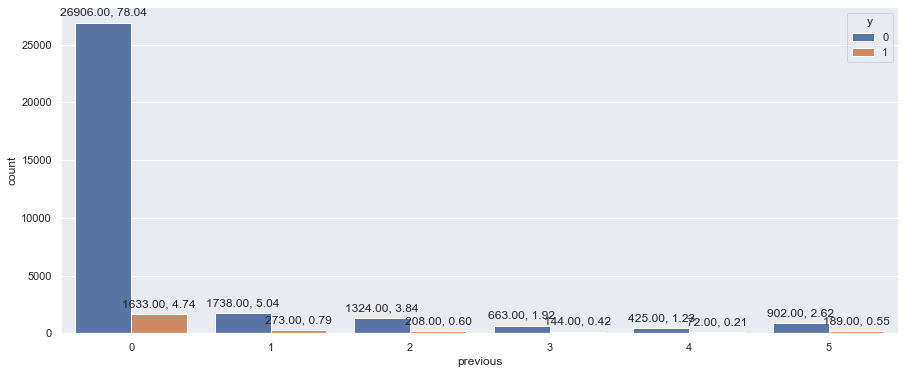

In [52]:
plt.figure(figsize=(15, 6))
ax = sns.countplot(x = train['previous'], hue=train['y'])
label_values(ax)
plt.show() 

I do not see any significant trend for values higher than 0. I believe this feature to be high correlated with "pdays", and for this reason I will drop it.

In [53]:
train.drop(columns = ["previous"], inplace = True)
test.drop(columns = ["previous"], inplace = True)

# 3. Encoding and Missing Values

In [54]:
train.head()

,age,job,marital,education,balance,housing,loan,contact,month,campaign,pdays,poutcome,y
0,38.0,blue-collar,married,secondary,0,no,no,unknown,jun,1,999,unknown,0
1,51.0,services,divorced,secondary,0,no,no,telephone,jul,4,999,unknown,0
2,46.0,admin.,married,secondary,-143,yes,no,unknown,may,8,999,unknown,0
3,48.0,services,married,secondary,400,yes,yes,cellular,aug,1,999,unknown,0
4,25.0,management,single,tertiary,1348,yes,no,unknown,may,1,999,unknown,0


There are 0.63% unkown in "job", 4.18% of unkown data for "education", 30% of unkown for "contact" and 82.78% of unkown for "poutcome" (together with 10 NaN).
I would try to avoid skipping these values because we would loose many other information.
I propose the following strategy:
- since we have only 0.63% of data in "unkown", I replace them with the mode.
- "unkown" values in poutcome forms a class, since these represent new clients.
- for the remaining 4.18% and 30% of unkown values in "education" and "contact" respectively, I am proceeding by LabelEncoding the values without the missing values, add them and use KNN imputation for filling the missing values.

In [55]:
# check missing values
print(train.isna().sum())
print(test.isna().sum())

age          16
job           0
marital       0
education     0
balance       0
housing       0
loan          0
contact      46
month         0
campaign      0
pdays         0
poutcome     10
y             0
dtype: int64
age           7
job           0
marital       0
education     0
balance       0
housing       0
loan          0
contact      12
month         0
campaign      0
pdays         0
poutcome      0
y             0
dtype: int64


In [56]:
def getfullitemsforOHE(wholedf,featlist,sort=True): # for OneHotEncoder
    """
    wholedf should be the dataframe including both train and test set.
    """
    def sortornot(X):
        if sort==False:
            return X
        else:
            return sorted(X)
       
    fulllist=[]
    for feat in featlist:
        fulllist.append(sortornot(wholedf[feat].unique()))
    return fulllist

In [57]:
# Age -> as we already discuss, I create this encoding: 0 for age <= 33, 1 for age > 33 and age < 60, 2 for age >= 60
# Then, I use a one hot encoder
train["age"] = train["age"].apply(lambda x: "young" if x<=33 else ("old" if x>= 60 else "middle"))
test["age"] = test["age"].apply(lambda x: "young" if x<=33 else ("old" if x>= 60 else "middle"))

# Job, Marital, Month and poutcome -> One Hot Encoding
# I assign the unkown to the category with highest frequence (mode)
train['job'] = train['job'].replace(['unknown'],train["job"].mode()[0])
test['job'] = test['job'].replace(['unknown'],train["job"].mode()[0]) # I use the mode in train also in the test set!
# since there are just 10 values missing (NaN) in poutcome, I use the mode as well
train['poutcome'].fillna(train["poutcome"].mode()[0],inplace=True)
test['poutcome'].fillna(test["poutcome"].mode()[0],inplace=True)
# I use OneHotEncoder since I do not have any particular order here
cat_columns = ["job", "marital", "month", "poutcome","age"]
# train+test -> fit_transform only on train and transform on test
whole=pd.concat([train,test],axis=0)
cats=getfullitemsforOHE(whole,cat_columns)
ohe=OneHotEncoder(categories=cats, sparse=False,handle_unknown="ignore")
X_trans=ohe.fit_transform(train[cat_columns])
X_trans=pd.DataFrame(X_trans,columns=ohe.get_feature_names(cat_columns))
x_test_trans=ohe.transform(test[cat_columns])
x_test_trans=pd.DataFrame(x_test_trans,columns=ohe.get_feature_names(cat_columns))
train.drop(columns =["job","marital","month","poutcome","age"],inplace=True)
test.drop(columns =["job","marital","month","poutcome","age"],inplace=True)
# concatane to get the original datasets with new OHE columns
train=pd.concat([train, X_trans],axis=1)
test=pd.concat([test, x_test_trans],axis=1)

# Balance and Pdays and Campaign -> MinMaxScaler (not sure about campaign, but if I leave like this, it has too big values comparing to other features)
scaler = MinMaxScaler()
train[["balance","pdays","campaign"]] = scaler.fit_transform(train[["balance","pdays","campaign"]])
test[["balance","pdays","campaign"]]  = scaler.transform(test[["balance","pdays","campaign"]] )

# Housing and Loan -> yes:1, no:0
train['housing'] = train['housing'].apply(lambda x: 0 if x == 'no' else 1)
test['housing'] = test['housing'].apply(lambda x: 0 if x == 'no' else 1)
train['loan'] = train['loan'].apply(lambda x: 0 if x == 'no' else 1)
test['loan'] = test['loan'].apply(lambda x: 0 if x == 'no' else 1)



c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
encoder = OrdinalEncoder()
# create a list of categorical columns to iterate over
cat_cols = ['education','contact']

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #replace unkown with nan
    data = data.replace(['unknown'],np.nan)
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for column in cat_cols:
    train[column] = encode(train[column])
    test[column] = encode(test[column])

In [59]:
from sklearn.impute import KNNImputer

X_train, y_train = train.drop(['y'],1), train['y']
X_test, y_test = test.drop(['y'],1), test['y']

# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X_train)
# transform the dataset
Xtrans_train = imputer.transform(X_train)
Xtrans_test = imputer.transform(X_test)
# reconvert to dataframe
X_train = pd.DataFrame(Xtrans_train,columns = X_train.columns)
X_test = pd.DataFrame(Xtrans_test,columns = X_test.columns)
# round to integer
X_train['education'] = X_train['education'].round(decimals = 0)
X_train['contact'] = X_train['contact'].round(decimals = 0)
X_test['education'] = X_test['education'].round(decimals = 0)
X_test['contact'] = X_test['contact'].round(decimals = 0)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_22320\3518290741.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, y_train = train.drop(['y'],1), train['y']
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_22320\3518290741.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test, y_test = test.drop(['y'],1), test['y']


In [60]:
X = pd.concat([X_train,y_train],axis=1)

In [61]:
X

,education,balance,housing,loan,contact,campaign,pdays,job_admin.,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_middle,age_old,age_young,y
0,1.0,0.072803,0.0,0.0,0.0,0.000000,1.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,1.0,0.072803,0.0,0.0,1.0,0.428571,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
2,1.0,0.071505,1.0,0.0,0.0,1.000000,1.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
3,1.0,0.076435,1.0,1.0,0.0,0.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
4,2.0,0.085042,1.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34472,1.0,0.117998,1.0,0.0,0.0,0.000000,1.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
34473,0.0,0.067211,1.0,0.0,0.0,0.000000,0.156313,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
34474,0.0,0.068781,1.0,0.0,0.0,0.000000,1.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
34475,0.0,0.077688,0.0,0.0,0.0,0.428571,1.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1


Last steps before training is analysing the correlation between features.

<AxesSubplot:>

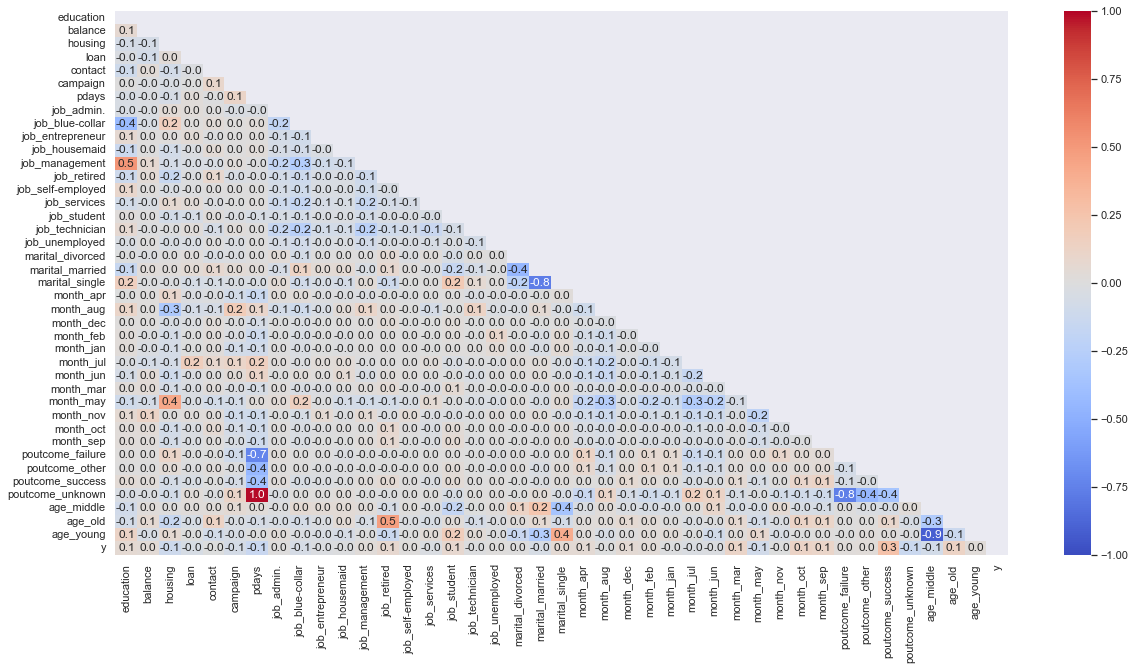

In [62]:
# Generate correlation matrix heat map to check which feature has greatest influence on the output 
fig, ax = plt.subplots(figsize = (20, 10))
matrix = np.triu(X.corr())
sns.heatmap(X.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)

IMPORTANT REMARK !!
We should drop some features since they are totally uncorrelated with the output. This might create overfitting.
In a first step, I consider the whole dataset. Then, I consider a subset of correlated features.
In order to avoid to write cells twice, PLEASE rerun everything based on the case.

In [149]:
# features to drop with 0 correlation with output

#X_train.drop(columns=["poutcome_unknown","balance","loan","contact","job_admin.","job_entrepreneur","job_housemaid","job_management","job_self-employed","job_services","job_technician","job_unemployed","marital_divorced","marital_married","marital_single","month_aug","month_feb","month_jan","month_jul","month_jun","month_nov","poutcome_failure","poutcome_other","age_young"],inplace=True)
#X_test.drop(columns=["poutcome_unknown","balance","loan","contact","job_admin.","job_entrepreneur","job_housemaid","job_management","job_self-employed","job_services","job_technician","job_unemployed","marital_divorced","marital_married","marital_single","month_aug","month_feb","month_jan","month_jul","month_jun","month_nov","poutcome_failure","poutcome_other","age_young"],inplace=True)

# 4. Models

For the training part, I will use different classification models. For each one, I will look for the best set of parameters via 5-Fold CV on the train set and then train the best model (with the best parameters) on the whole training set and evaluate it on the test set. For the evaluation, I will consider the following metrics as the dataset is unbalanced: AUC, Recall, Precision, F1 score. In particular, for Grid Search CV, I set the F1-score as metric to be optimized, since it is the harmonic mean of precision and recall. Finally, I will try to use the SMOTE technique to rembalance the dataset.

Models:
- Logistic Regression
- Random Forest
- Gradient Boosting
- XGBoost

Methods:
- without SMOTE
- with SMOTE

In [63]:
def draw_roc( train_actual, train_probs, test_actual, test_probs ):
    train_fpr, train_tpr, train_thresholds = metrics.roc_curve( train_actual, train_probs,
                                              drop_intermediate = False )
    test_fpr, test_tpr, test_thresholds = metrics.roc_curve( test_actual, test_probs,
                                              drop_intermediate = False )
    train_auc_score = metrics.roc_auc_score( train_actual, train_probs )
    test_auc_score = metrics.roc_auc_score( test_actual, test_probs )
    plt.figure(figsize=(5, 5))
    plt.plot( train_fpr, train_tpr, label='ROC curve train (area = %0.2f)' % train_auc_score )
    plt.plot( test_fpr, test_tpr, label='ROC curve test (area = %0.2f)' % test_auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [64]:
# Train model using hyperparmeter tuning
def training_model_hyperparameter(model, scoring, params_grid, X_train, y_train, smote):
    if smote == True:
        pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=100)],
                                ['classifier', model]])
    else:
        pipeline = model

    folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state=100)

    grid = GridSearchCV(estimator = pipeline, scoring=scoring, param_grid = params_grid, cv = folds, 
                           verbose=0, return_train_score=True, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid

In [65]:
# Predict values and propability of training and testing data
def prediction_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    return y_train_pred, y_train_pred_prob, y_test_pred, y_test_pred_prob

1 - Logistic Regression

In [66]:
lr_model = LogisticRegression()

In [67]:
# Create the param grid for logistic regression
lr_param_grid = {
    'max_iter': [75, 100, 125],
    'penalty': ['l1', 'l2'],
    'C': [0.5 , 1, 1.5],
    'solver': ['liblinear', 'lbfgs']
}
print(lr_param_grid)

{'max_iter': [75, 100, 125], 'penalty': ['l1', 'l2'], 'C': [0.5, 1, 1.5], 'solver': ['liblinear', 'lbfgs']}


In [68]:
lr_grid = training_model_hyperparameter(lr_model, 'f1', lr_param_grid, X_train, y_train, False) 
lr_grid.best_params_

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Alessandro\AppDat

{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [69]:
y_train_pred_lr, y_train_pred_lr_prob, y_test_pred_lr, y_test_pred_lr_prob = prediction_model(lr_grid, X_train, y_train, X_test, y_test)
# NOTE: lr_grid.predict() (applied in prediction_model) exploits the best set of parameters found with grid search CV.

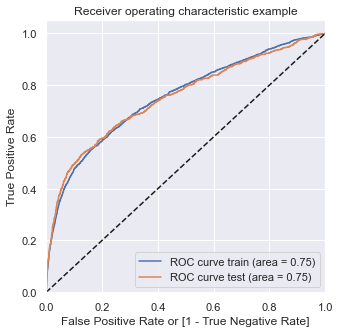

In [70]:
draw_roc(y_train, y_train_pred_lr_prob, y_test, y_test_pred_lr_prob)

In [71]:
cm_lr_model = confusion_matrix(y_test, y_test_pred_lr)
cm_lr_model

array([[7925,   42],
       [ 582,   71]], dtype=int64)

In [72]:
print("Logistic Regression:\n") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_lr),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_lr),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_lr),2)))

Logistic Regression:

recall: 0.11
precision: 0.63
F1 score: 0.19


2. Random Forest Classifier

In [73]:
# Create the param grid for random forest
param_grid_rf = [{'n_estimators': [30, 50, 75, 100],
               'max_depth': [5, 6, 7, 8, 9, 10],
               'max_features': [10, 15, 25, 30]}]

In [74]:
rf_model = RandomForestClassifier()

In [75]:

rf_grid = training_model_hyperparameter(rf_model, 'f1', param_grid_rf, X_train, y_train,False)
rf_grid.best_params_

{'max_depth': 8, 'max_features': 25, 'n_estimators': 50}

In [76]:
y_train_pred_rf, y_train_pred_rf_prob, y_test_pred_rf, y_test_pred_rf_prob = prediction_model(rf_grid, X_train, y_train, X_test, y_test)

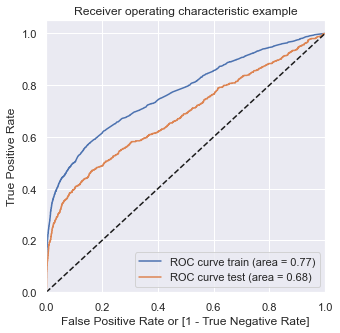

In [77]:
draw_roc(y_train, y_train_pred_rf_prob, y_test, y_test_pred_rf_prob)

In [78]:
cm_rf= confusion_matrix(y_test, y_test_pred_rf)
cm_rf

array([[7919,   48],
       [ 565,   88]], dtype=int64)

In [79]:
print("Random Forest:\n") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_rf),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_rf),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_rf),2)))

Random Forest:

recall: 0.13
precision: 0.65
F1 score: 0.22


3. Gradient Boosting Classifier

In [80]:
gb_model = GradientBoostingClassifier(verbose = 1)

In [81]:
params_grid_gb = {
    "n_iter_no_change": ['None', 5, 10],
    "n_estimators": [30, 50, 75, 100],
    "learning_rate": [0.05, 0.1, 0.15]
}

In [82]:
gb_grid = training_model_hyperparameter(gb_model, 'f1', params_grid_gb, X_train, y_train, False)
gb_grid.best_params_

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py", line 577, in fit
    self._check_params()
  File "c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages

      Iter       Train Loss   Remaining Time 
         1           0.4989            2.63s
         2           0.4888            2.67s
         3           0.4823            2.72s
         4           0.4779            2.70s
         5           0.4723            2.71s
         6           0.4693            2.90s
         7           0.4671            2.87s
         8           0.4649            2.88s
         9           0.4621            2.86s
        10           0.4595            2.82s
        20           0.4449            2.46s
        30           0.4378            2.16s
        40           0.4344            1.84s
        50           0.4316            1.53s
        60           0.4287            1.23s


{'learning_rate': 0.15, 'n_estimators': 100, 'n_iter_no_change': 10}

In [83]:
y_train_pred_gb, y_train_pred_gb_prob, y_test_pred_gb, y_test_pred_gb_prob = prediction_model(gb_grid, X_train, y_train, X_test, y_test)

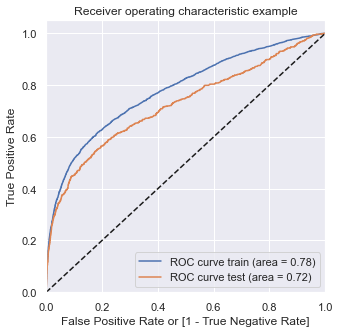

In [84]:
draw_roc(y_train, y_train_pred_gb_prob, y_test, y_test_pred_gb_prob)

In [85]:
cm_gb= confusion_matrix(y_test, y_test_pred_gb)
cm_gb

array([[7914,   53],
       [ 562,   91]], dtype=int64)

In [86]:
print("Gradient Boosting:\n") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_gb),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_gb),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_gb),2)))

Gradient Boosting:

recall: 0.14
precision: 0.63
F1 score: 0.23


4. XGBoost

In [87]:
xgb_model = XGBClassifier()

In [88]:
params_grid_xgb = {
               'max_depth': [5, 7],
               'max_features': [10, 20, 30]}

In [89]:
xgb_grid = training_model_hyperparameter(xgb_model, 'f1', params_grid_xgb, X_train, y_train, False)
xgb_grid.best_params_

[20:56:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




{'max_depth': 5, 'max_features': 10}

In [90]:
y_train_pred_xgb, y_train_pred_xgb_prob, y_test_pred_xgb, y_test_pred_xgb_prob = prediction_model(xgb_grid, X_train, y_train, X_test, y_test)

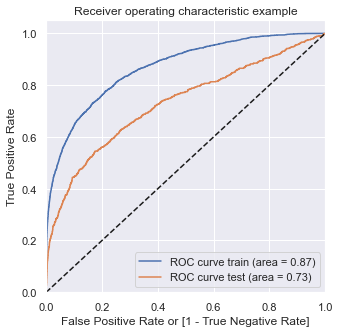

In [91]:
draw_roc(y_train, y_train_pred_xgb_prob, y_test, y_test_pred_xgb_prob)

In [92]:
cm_xgb= confusion_matrix(y_test, y_test_pred_xgb)
cm_xgb

array([[7919,   48],
       [ 565,   88]], dtype=int64)

In [93]:
print("XGBoost:\n") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_xgb),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_xgb),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_xgb),2)))

XGBoost:

recall: 0.13
precision: 0.65
F1 score: 0.22


# 5. SMOTE

REMARK: I tried to use SMOTE with CV, but it takes too much time for training.
In order to simplify, I am using SMOTE on all training set. Then, I train the best models found before on this set and I evaluate them on the test set (that did not get oversampling!).

I compare AUC, Recall, Precision and F1 score of all methods in next section.

In [94]:
sm = SMOTE()
X_sm , y_sm = sm.fit_resample(X_train, y_train)

In [95]:
y_sm.value_counts()

0    31958
1    31958
Name: y, dtype: int64

1. Logistic Regression

In [96]:
lr_model2 = LogisticRegression(**lr_grid.best_params_)

In [97]:
lr_model2.fit(X_sm,y_sm)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [98]:
y_train_pred_lr2, y_train_pred_lr_prob2, y_test_pred_lr2, y_test_pred_lr_prob2 = prediction_model(lr_model2, X_sm, y_sm, X_test, y_test)

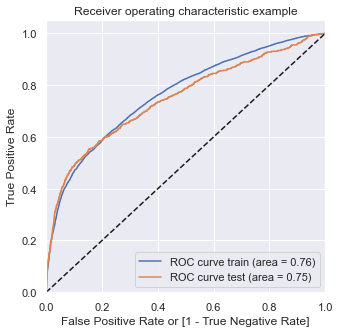

In [99]:
draw_roc(y_sm, y_train_pred_lr_prob2, y_test, y_test_pred_lr_prob2)

In [100]:
cm_lr2= confusion_matrix(y_test, y_test_pred_lr2)
cm_lr2

array([[4720, 3247],
       [ 172,  481]], dtype=int64)

In [101]:
print("Linear Regression with SMOTE:\n") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_lr2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_lr2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_lr2),2)))

Linear Regression with SMOTE:

recall: 0.74
precision: 0.13
F1 score: 0.22


2. Random Forest

In [102]:
rf_model2 = RandomForestClassifier(**rf_grid.best_params_)
rf_model2

RandomForestClassifier(max_depth=8, max_features=25, n_estimators=50)

In [103]:
rf_model2.fit(X_sm,y_sm)

RandomForestClassifier(max_depth=8, max_features=25, n_estimators=50)

In [104]:
y_train_pred_rf2, y_train_pred_rf_prob2, y_test_pred_rf2, y_test_pred_rf_prob2 = prediction_model(rf_model2, X_sm, y_sm, X_test, y_test)

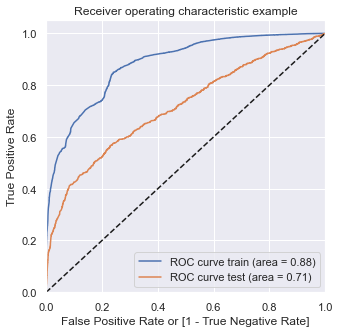

In [105]:
draw_roc(y_sm, y_train_pred_rf_prob2, y_test, y_test_pred_rf_prob2)

In [106]:
cm_rf2= confusion_matrix(y_test, y_test_pred_rf2)
cm_rf2

array([[6366, 1601],
       [ 311,  342]], dtype=int64)

In [107]:
print("Random Forest with SMOTE:\n") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_rf2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_rf2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_rf2),2)))

Random Forest with SMOTE:

recall: 0.52
precision: 0.18
F1 score: 0.26


3. Gradient Boosting

In [108]:
gb_model2 = GradientBoostingClassifier(**gb_grid.best_params_)
gb_model2

GradientBoostingClassifier(learning_rate=0.15, n_iter_no_change=10)

In [109]:
gb_model2.fit(X_sm,y_sm)

GradientBoostingClassifier(learning_rate=0.15, n_iter_no_change=10)

In [110]:
y_train_pred_gb2, y_train_pred_gb_prob2, y_test_pred_gb2, y_test_pred_gb_prob2 = prediction_model(gb_model2, X_sm, y_sm, X_test, y_test)

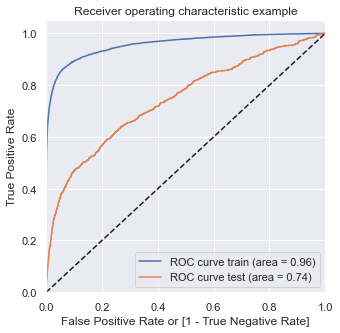

In [111]:
draw_roc(y_sm, y_train_pred_gb_prob2, y_test, y_test_pred_gb_prob2)

In [112]:
cm_gb2= confusion_matrix(y_test, y_test_pred_gb2)
cm_gb2

array([[7582,  385],
       [ 417,  236]], dtype=int64)

In [113]:
print("Gradient Boosting with SMOTE:\n") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_gb2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_gb2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_gb2),2)))

Gradient Boosting with SMOTE:

recall: 0.36
precision: 0.38
F1 score: 0.37


4. XGBoost

In [114]:
xgb_model2 = XGBClassifier(**xgb_grid.best_params_)
xgb_model2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_features=10, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=None, reg_alpha=None, ...)

In [115]:
xgb_model2.fit(X_sm,y_sm)

[20:56:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_features=10, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [116]:
y_train_pred_xgb2, y_train_pred_xgb_prob2, y_test_pred_xgb2, y_test_pred_xgb_prob2 = prediction_model(xgb_model2, X_sm, y_sm, X_test, y_test)

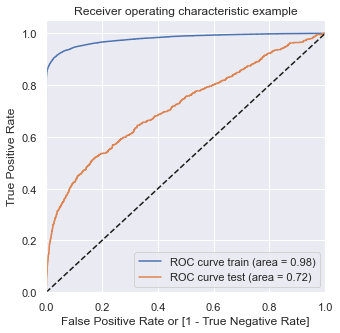

In [117]:
draw_roc(y_sm, y_train_pred_xgb_prob2, y_test, y_test_pred_xgb_prob2)

In [118]:
cm_xgb2= confusion_matrix(y_test, y_test_pred_xgb2)
cm_xgb2

array([[7827,  140],
       [ 514,  139]], dtype=int64)

In [119]:
print("XGBoost with SMOTE:\n") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_xgb2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_xgb2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_xgb2),2)))

XGBoost with SMOTE:

recall: 0.21
precision: 0.5
F1 score: 0.3


# 6. Final Remarks

In [120]:
print("Logistic Regression:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_lr),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_lr),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_lr),2)))
print("Random Forest:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_rf),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_rf),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_rf),2)))
print("Gradient Boosting:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_gb),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_gb),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_gb),2)))
print("XGBoost:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_xgb),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_xgb),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_xgb),2)))
print("\n")
print("Linear Regression with SMOTE:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_lr2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_lr2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_lr2),2)))
print("Random Forest with SMOTE:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_rf2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_rf2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_rf2),2)))
print("Gradient Boosting with SMOTE:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_gb2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_gb2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_gb2),2)))
print("XGBoost with SMOTE:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_xgb2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_xgb2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_xgb2),2)))

Logistic Regression:
recall: 0.11
precision: 0.63
F1 score: 0.19
Random Forest:
recall: 0.13
precision: 0.65
F1 score: 0.22
Gradient Boosting:
recall: 0.14
precision: 0.63
F1 score: 0.23
XGBoost:
recall: 0.13
precision: 0.65
F1 score: 0.22


Linear Regression with SMOTE:
recall: 0.74
precision: 0.13
F1 score: 0.22
Random Forest with SMOTE:
recall: 0.52
precision: 0.18
F1 score: 0.26
Gradient Boosting with SMOTE:
recall: 0.36
precision: 0.38
F1 score: 0.37
XGBoost with SMOTE:
recall: 0.21
precision: 0.5
F1 score: 0.3


By comparing all 8 models (SMOTE and not SMOTE) I can make the following remarks:
- In general, SMOTE technique improved the performances of models for this task, in terms of Recall and F1-score.
- The highest recall is obtained with LR with SMOTE. The highest precision with RF and GB without SMOTE. The highest F1 score with GB with SMOTE.
- The large gaps between AUC in RF, GB and XGB (especially with SMOTE) might imply an overfitting problem. The linear regression instead is better from this point of view.

I redo steps 4 and 5 but with model selection done at end of point 3:

6.1. After Feature Selection (go back end of point 4)

In [204]:
print("Logistic Regression:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_lr),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_lr),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_lr),2)))
print("Random Forest:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_rf),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_rf),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_rf),2)))
print("Gradient Boosting:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_gb),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_gb),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_gb),2)))
print("XGBoost:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_xgb),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_xgb),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_xgb),2)))
print("\n")
print("Linear Regression with SMOTE:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_lr2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_lr2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_lr2),2)))
print("Random Forest with SMOTE:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_rf2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_rf2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_rf2),2)))
print("Gradient Boosting with SMOTE:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_gb2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_gb2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_gb2),2)))
print("XGBoost with SMOTE:") 
print("recall: {}".format(round(metrics.recall_score(y_test, y_test_pred_xgb2),2)))
print("precision: {}".format(round(metrics.precision_score(y_test, y_test_pred_xgb2),2)))
print("F1 score: {}".format(round(metrics.f1_score(y_test, y_test_pred_xgb2),2)))

Logistic Regression:
recall: 0.1
precision: 0.6
F1 score: 0.18
Random Forest:
recall: 0.16
precision: 0.36
F1 score: 0.22
Gradient Boosting:
recall: 0.18
precision: 0.31
F1 score: 0.23
XGBoost:
recall: 0.16
precision: 0.44
F1 score: 0.24


Linear Regression with SMOTE:
recall: 0.74
precision: 0.12
F1 score: 0.21
Random Forest with SMOTE:
recall: 0.32
precision: 0.33
F1 score: 0.32
Gradient Boosting with SMOTE:
recall: 0.34
precision: 0.37
F1 score: 0.36
XGBoost with SMOTE:
recall: 0.23
precision: 0.41
F1 score: 0.3


No significant differences with the whole dataset training and evaluation.

Final comment:

The best model depends on the problem scope. The goal is to predict if a customer will subscribe a term deposit or not. By sure, the attention should be put on the smaller class (y=1), but in order to understand which metric is the best one, we have to understand if a False Negative (FN) costs more than a False Positive (FP), so that Recall is more important than Precision. The cost of a FN is the amount of value that a new customer would bring. The cost of a FP correspond to the sum of calls costs and labor costs. However, I believe that for a bank the first cost is definitely more important than the second, since they want to increase the number of clients subscripted.
How much is more important? Should we look at F1 or Recall? This is difficult to say, but probably the Recall here is more significant than F1 score for the reason already explained and, then, the LR with SMOTE is the best model. However, in order to give a more robust answer, an analysis over the costs above mentioned should be done previously.

Next steps:

Firstly, I would try to modify our dataset (considering a different way of encoding or binning the variables or creating new features by combining the existing ones). If this does not work, I can try to use more complex model (e.g., Neural Networks).